In [2]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset("RealTimeData/bbc_news_alltime", "2017-01")
texts = [item["content"] for item in dataset["train"] if item["content"]]

Generating train split: 100%|██████████| 1688/1688 [00:00<00:00, 8770.74 examples/s]


In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts[:200], show_progress_bar=True)

Batches: 100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


In [5]:
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.5
G = nx.Graph()
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [6]:
partition = community_louvain.best_partition(G, weight="weight")

In [7]:
clusters = {}
for node, comm in partition.items():
    clusters.setdefault(comm, []).append(texts[node])

community_keywords = {}
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

for comm, docs in clusters.items():
    X = vectorizer.fit_transform(docs)
    # Compute mean TF-IDF score per word
    scores = X.toarray().mean(axis=0)
    top_indices = scores.argsort()[-5:][::-1]  # top 5 words
    keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    community_keywords[comm] = ", ".join(keywords)

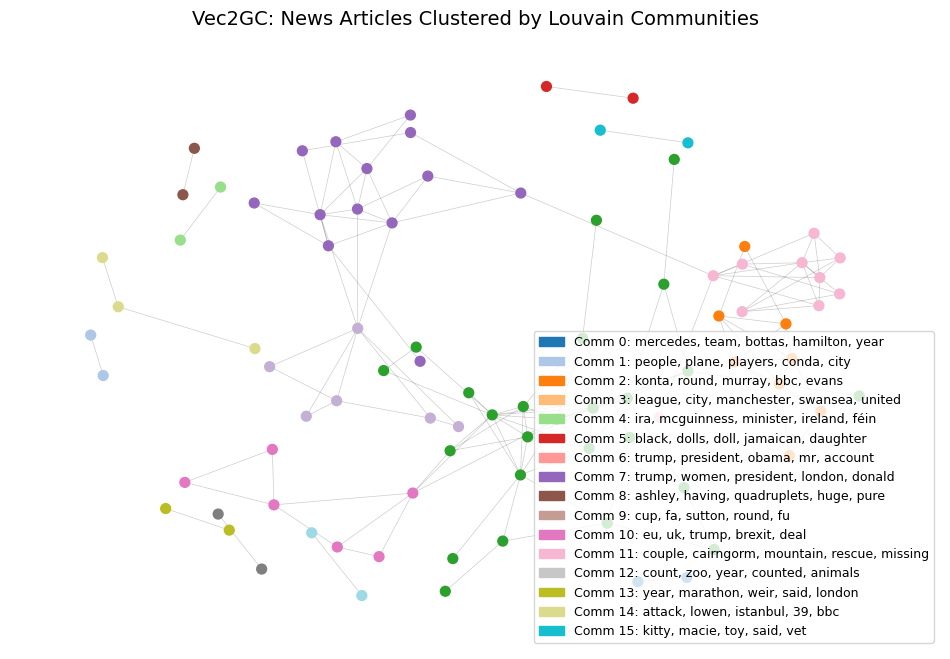

In [8]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)

colors = [partition[node] for node in G.nodes()]
unique_comms = sorted(set(colors))

nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Legend patches with keywords
patches = [mpatches.Patch(color=plt.cm.tab20(i/len(unique_comms)),
                          label=f"Comm {i}: {community_keywords[i]}")
           for i in unique_comms]

plt.legend(handles=patches, loc="best", fontsize=9)
plt.title("Vec2GC: News Articles Clustered by Louvain Communities", fontsize=14)
plt.axis("off")
plt.show()